In [13]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/akima/.virtualenvs/mn/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.5.0
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/akima/Documents/mn/repo/tp2
-- Configuring done
-- Generating do

In [14]:
import metnum
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score, confusion_matrix
from timeit import default_timer as timer

!rm -r balanceo_results
!mkdir balanceo_results

In [15]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca

In [17]:
def sRange(final, amount):
    for i in range(1, final, final//(amount-1)):
        yield i
    yield final

In [37]:
def correr(k, alpha, trainDF, testDF):
    X_train = trainDF[trainDF.columns[1:]].values
    y_train = trainDF["label"].values.reshape(-1, 1)

    X_val = testDF[trainDF.columns[1:]].values
    y_val = testDF["label"].values.reshape(-1, 1)

    start = timer()
    X_pca, X_val_pca = pca(alpha, X_train, X_val)

    clf = metnum.KNNClassifier(k)
    clf.fit(X_pca, y_train)
    clf.load(X_val_pca)
    y_pred = clf.predict(k)    
    time = timer() - start

    acc = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred,average = None)
    precision = precision_score(y_val, y_pred, average=None)
    f1 = f1_score(y_val, y_pred, average = None)
    
    return acc, recall, precision, f1, y_val, y_pred, time

In [38]:
def exp(expName, res, k, alpha, trainDF, testDF):
    acc, recall, precision, f1, y_val, y_pred, time = correr(k, alpha, trainDF, testDF)
    
    res.append({'expName':expName, 'acc':acc, 'recall':recall, 'precision':precision, 'f1':f1, 'y_val':y_val, 'y_pred':y_pred, 'time':time})
        
    #Confusion matrix
    cm = confusion_matrix(y_val, y_pred, normalize = "true")
    #PONEMOS CEROS EN LA DIAGONAL PARA VISUALIZAR MEJOR EL HEATPMAP
    np.fill_diagonal(cm, 0, wrap=False)
    plt.figure(figsize=(14,10))
    sns.heatmap(cm,cmap = "YlGnBu",annot = True)
    title = f"{expName} con alpha:{alpha} y k:{k}"
    plt.title(title)
    plt.savefig(f"balanceo_results/{title}_{n}.png")
    plt.show()
    
    #recall & precision w/class
    ejex = [i for i in range(10)]

    sns.barplot(x = ejex , y = recall)
    title = f"{expName} recall"
    plt.title(title)
    plt.savefig(f"balanceo_results/{title}_{n}.png")
    # plt.ylim(min(recall)-0.01, 1.01) #escala para que se vea mejor la dif
    plt.ylim(0.7, 1.01)
    plt.show()

    sns.barplot(x = ejex , y = precision)
    title = f"{expName} precision"
    plt.title(title)
    plt.savefig(f"balanceo_results/{title}_{n}.png")
    # plt.ylim(min(precision)-0.01, 1.01)
    plt.ylim(0.7, 1.01)
    plt.show()

In [39]:
from math import floor
def obtenerDigitosEnProporcion(total, proporciones):
    res = pd.DataFrame()
    resto = total
    
    for digit, prop in enumerate(proporciones):
        amount = floor(total * prop) if digit!=9 else resto #no quiero pasarme del total, prefiero no tener la proporcion exacta en 9s *
        resto -= amount
        toAdd = df_datos.groupby("label").get_group(digit).iloc[:amount]
        res = res.append(toAdd)
    #* esto se podria calcular mejor
    return res

In [40]:
# Mejor (alpha, k): (50, 6)
# Mejor pareja de cross validation :(Alpha,k) = 35, 6
alpha = 40
k = 4

resultados = []

# Testeo preliminar con pocos datos

In [41]:
df_datos = pd.read_csv("../data/train.csv")
digits = list(range(10))

In [42]:
n = 5000
trainN = int(0.6 * n)

testDF = df_datos.groupby('label').tail(n-trainN)

print(f"Ahora tengo {trainN} instancias de entrenamiento y {n-trainN} de validación")

Ahora tengo 3000 instancias de entrenamiento y 2000 de validación


In [43]:
proportions = [0.1]*10
trainDF = obtenerDigitosEnProporcion(trainN, proportions)
trainDF["label"].value_counts(normalize=True)

9    0.1
7    0.1
5    0.1
3    0.1
1    0.1
8    0.1
6    0.1
4    0.1
2    0.1
0    0.1
Name: label, dtype: float64

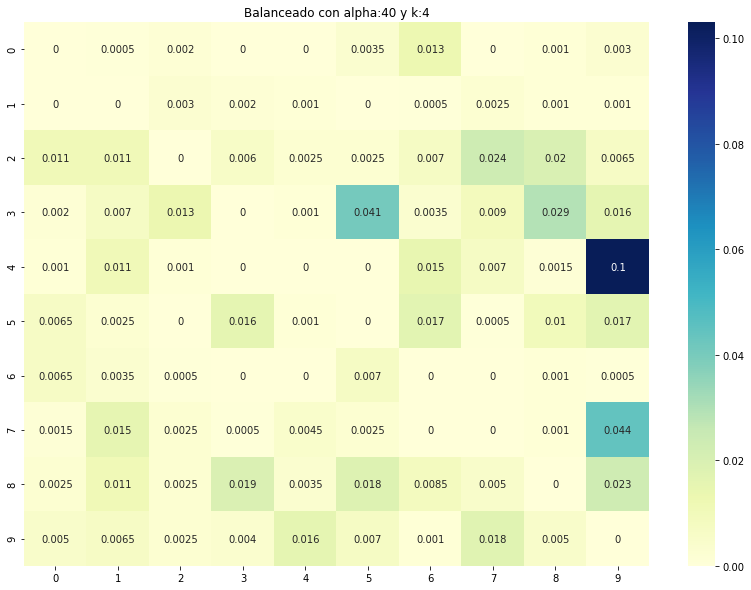

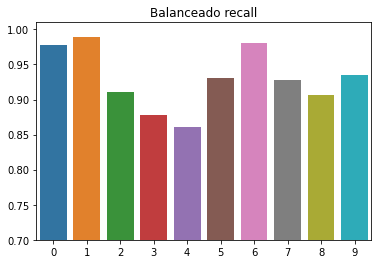

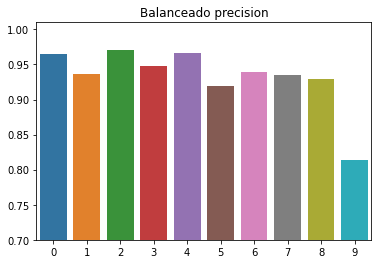

In [44]:
exp('Balanceado', resultados, k, alpha, trainDF, testDF)

La precision del 9 es la mas baja, veamos si se puede mejorar agregando mas instancias de ese tipo

# Agrego instancias de 9s

In [45]:
proportions = [0.093]*10
proportions[9] = 0.16
trainDF = obtenerDigitosEnProporcion(trainN, proportions)
trainDF["label"].value_counts(normalize=True)

9    0.163
7    0.093
5    0.093
3    0.093
1    0.093
8    0.093
6    0.093
4    0.093
2    0.093
0    0.093
Name: label, dtype: float64

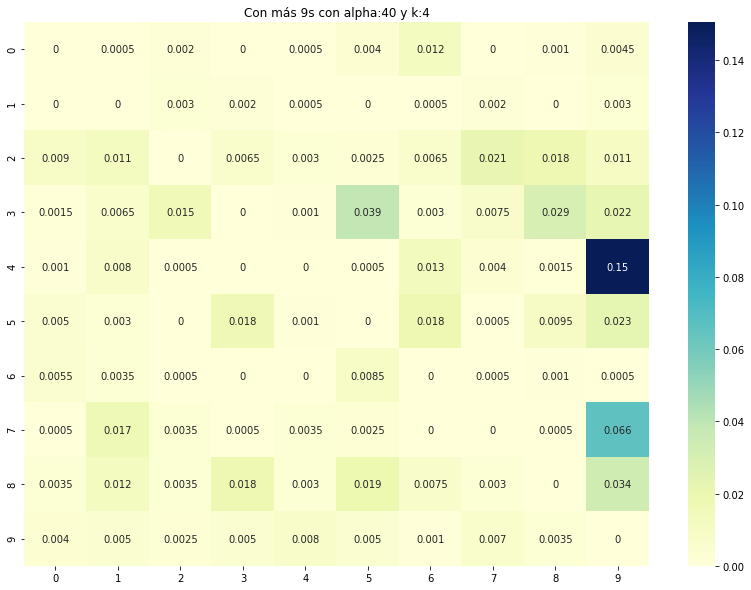

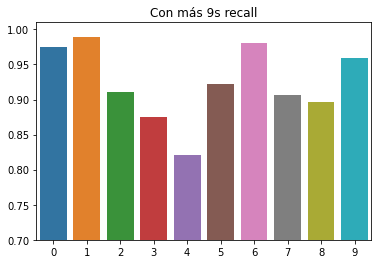

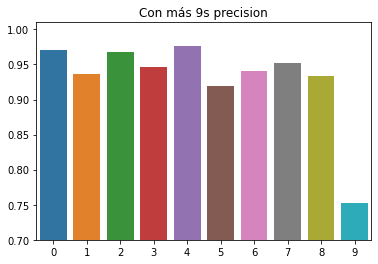

In [46]:
exp('Con más 9s', resultados, k, alpha, trainDF, testDF)

nop, se confunde muchos 4s con 9s entonces termina empeorando tanto el recall del 4 como la precision del 9

# Que pasa si en vez de 9s hubiesemos agregado 4s?

In [47]:
proportions = [((1-0.16)/9)]*10
proportions[4] = 0.16
trainDF = obtenerDigitosEnProporcion(trainN, proportions)
trainDF["label"].value_counts(normalize=True)

4    0.160
9    0.096
7    0.093
5    0.093
3    0.093
1    0.093
8    0.093
6    0.093
2    0.093
0    0.093
Name: label, dtype: float64

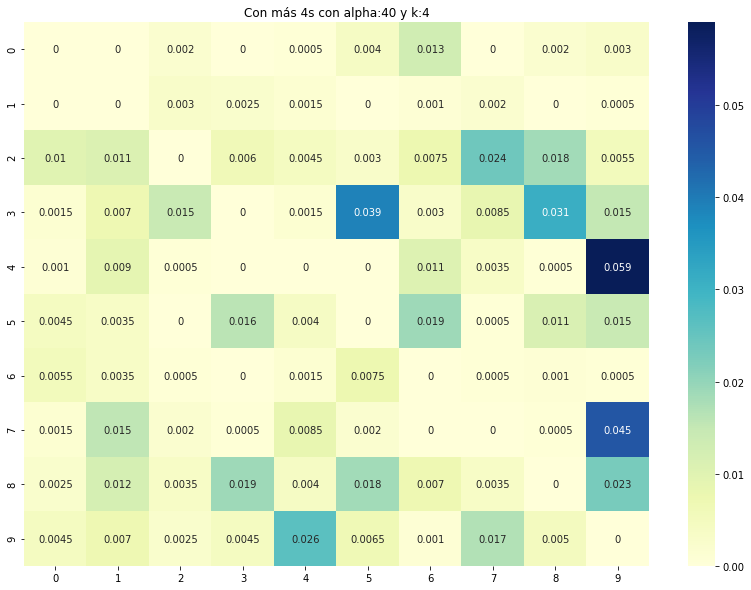

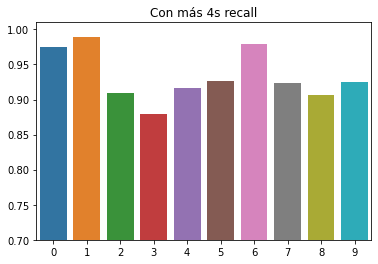

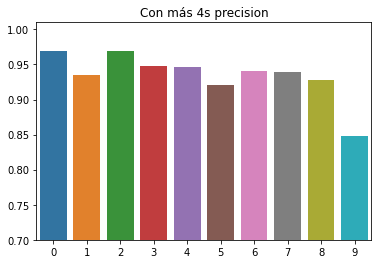

In [48]:
exp('Con más 4s', resultados, k, alpha, trainDF, testDF)

Mejora! mejor recall para el 4 sin bajar tanto el del 9 y mejor precisión en general.

# Una disposición que maximice accuracy
Aplicando la misma idea iremos modificando las proporciones, intentando aumentar el accuracy total

Primero quisimos ir agregando nuevos datos, pero esto aumenta el accuracy en general, sin importar mucho la proporción. Luego modificamos la experimentación para que permita tener una cantidad de entrenamiento fija pero que varíe las proporciones

In [49]:
proportions = [0.093]*10
proportions[4] = 0.15
proportions[3] = 0.11

trainDF = obtenerDigitosEnProporcion(trainN, proportions)
print(trainDF["label"].value_counts(normalize=True))

4    0.150
3    0.110
7    0.093
5    0.093
1    0.093
8    0.093
6    0.093
2    0.093
0    0.093
9    0.089
Name: label, dtype: float64


In [50]:
exp('Muchos 4s, más 3s', resultados, k, alpha, trainDF3, testDF1)

NameError: name 'trainDF3' is not defined

In [ ]:
proportions = [0.087]*10
proportions[4] = 0.15
proportions[3] = 0.11
proportions[7] = 0.11
proportions[8] = 0.11

trainDF = obtenerDigitosEnProporcion(trainN, proportions)
print(trainDF["label"].value_counts(normalize=True))

In [ ]:
exp('Muchos 4s, más 3s, 7s y 8s', resultados, k, alpha, trainDF, testDF)

# Comparando los resultados

In [ ]:
resultsDF = pd.DataFrame(resultados)
resultsDF

In [ ]:
ax = sns.barplot(x='expName', y='acc', data=resultsDF)
plt.title('comparando')
# plt.savefig(f"balanceo_results/acc.png")
plt.ylim(resultsDF.acc.min()-0.01, resultsDF.acc.max()+0.01)

#annotate axis
for p in ax.patches:
             ax.annotate(round(p.get_height(),3), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                 textcoords='offset points')

plt.show()

In [ ]:
precisionsDF = resultsDF[['expName']].join(resultsDF['precision'].apply(pd.Series))
precisionsDF

In [ ]:
for metrica in ['precision', 'recall', 'f1']:
    df = resultsDF[metrica].apply(pd.Series).transpose().reset_index()
    df.columns = ['Digito'] + list(resultsDF['expName'])
    
    ax = plt.gca()
    df.plot(x=df.columns[0], y=df.columns[1:], kind = 'bar', ax = ax)
    plt.title(metrica)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#     plt.savefig(f"balanceo_results/{metrica}_{n}.png")
    plt.ylim(0.7, 1.01)
    plt.show()